# Food Recipe Generation

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.applications import ResNet50,Xception,InceptionV3

K.clear_session()

## Loading the dataset 

In [2]:
dataset=r'C:\Users\Snehal Thakur\PycharmProjects\FoodImageRecipeGeneration\dataset\foodImages'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"test")
validation_folder = os.path.join(dataset,"validation")

## Counting number of images in the folder 

In [3]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 72 files in cheesecake
There are 72 files in french_fries
There are 72 files in hamburger
There are 72 files in hot_dog
There are 72 files in pizza


# 

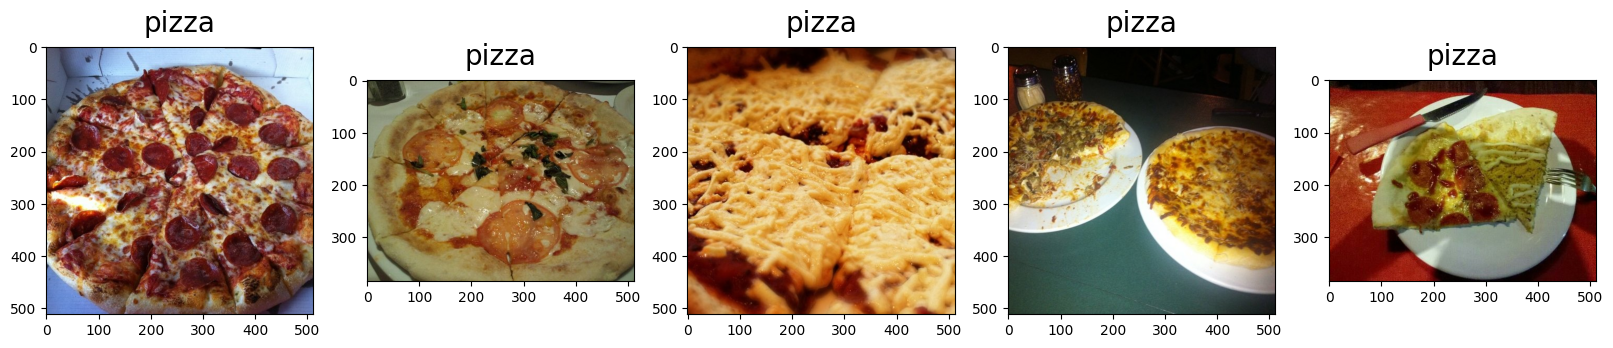

In [4]:
select_vegetable="pizza"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

## Random Images 

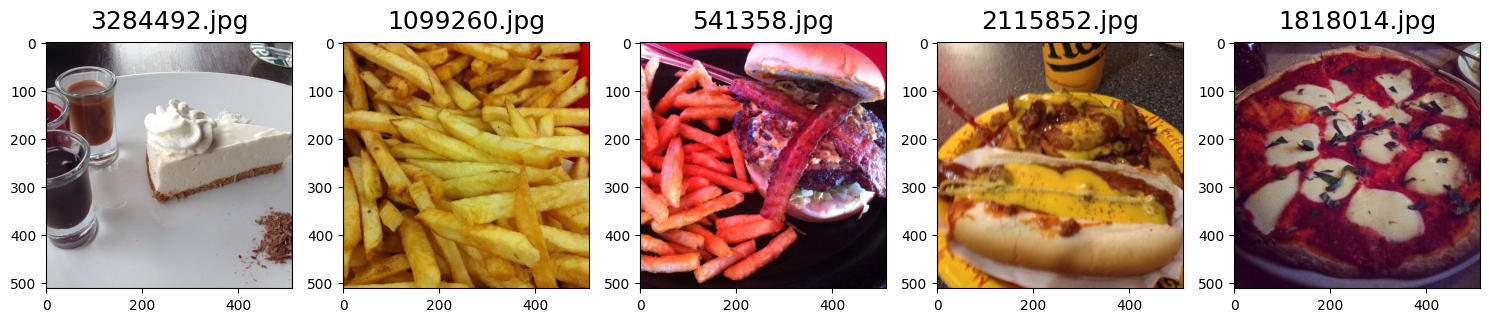

In [5]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-1]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

## Model Building 

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_set = train_datagen.flow_from_directory(
    r'C:\Users\Snehal Thakur\PycharmProjects\FoodImageRecipeGeneration\dataset\foodImages\train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

test_set = test_datagen.flow_from_directory(
    r'C:\Users\Snehal Thakur\PycharmProjects\FoodImageRecipeGeneration\dataset\foodImages\test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

val_set = test_datagen.flow_from_directory(
    r'C:\Users\Snehal Thakur\PycharmProjects\FoodImageRecipeGeneration\dataset\foodImages\validation',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')


Found 4500 images belonging to 5 classes.
Found 360 images belonging to 5 classes.
Found 140 images belonging to 5 classes.


In [8]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create the ImageDataGenerator object
# train_datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
# )

# val_datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
# ) 

# # Generate batches and augment the images
# train_generator = train_datagen.flow_from_dataframe(
#     df_train,
#     directory='Food-5K/training/',
#     x_col='filename',
#     y_col='label',
#     class_mode='binary',
#     target_size=(224, 224),
# )

# val_generator = train_datagen.flow_from_dataframe(
#     df_val,
#     directory='Food-5K/validation/',
#     x_col='filename',
#     y_col='label',
#     class_mode='binary',
#     target_size=(224, 224),
# )

In [9]:
from tensorflow.keras.applications import ResNet50

# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(224, 224, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(224, 224, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(5, activation='softmax')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
model.fit(train_set, epochs=20, validation_data=val_set)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\traitlets\config\application.py", line 985, in launch_instance
      app.start()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Snehal Thakur\AppData\Local\Temp\ipykernel_6944\1923527049.py", line 1, in <module>
      model.fit(train_set, epochs=20, validation_data=val_set)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [20,5] and labels shape [100]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_9972]

In [ ]:
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for i in os.listdir('Food-5K/evaluation'):
    img = Image.open('Food-5K/evaluation/' + i)
    img = img.resize((224, 224))
    img = np.array(img)
    img = np.expand_dims(img, 0)
    
    y_true.append(int(i.split('_')[0]))
    y_pred.append(1 if model.predict(img) > 0.5 else 0)
    
print(classification_report(y_true, y_pred))
print()
print(confusion_matrix(y_true, y_pred))

In [ ]:
# checkpoint_save_path = './Model.ckpt'
# if os.path.exists(checkpoint_save_path + '.index'):
#     net.load_weights(checkpoint_save_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
#                                                  save_best_only=True)

# history = net.fit(train_ds, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback])

# net.summary()

# file = open('./weights.txt', 'w')
# for v in net.trainable_variables:
#     file.write(str(v.name) + '\n')
#     file.write(str(v.shape) + '\n')
#     file.write(str(v.numpy()) + '\n')

# file.close()

In [ ]:
# from tensorflow.keras.applications import ResNet50

# # Initialize the Pretrained Model
# feature_extractor = ResNet50(weights='imagenet', 
#                              input_shape=(224, 224, 3),
#                              include_top=False)

# # Set this parameter to make sure it's not being trained
# feature_extractor.trainable = False

# # Set the input layer
# input_ = tf.keras.Input(shape=(224, 224, 3))

# # Set the feature extractor layer
# x = feature_extractor(input_, training=False)

# # Set the pooling layer
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Set the final layer with sigmoid activation function
# output_ = tf.keras.layers.Dense(1, activation='softmax')(x)

# # Create the new model object
# model = tf.keras.Model(input_, output_)

# # Compile it
# model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

# # Print The Summary of The Model
# model.summary()

In [ ]:
# train_datagen = image.ImageDataGenerator(rescale = 1./255,
#                                          shear_range = 0.2,
#                                          zoom_range = 0.2,
#                                          horizontal_flip = True)

# test_datagen = image.ImageDataGenerator(rescale = 1./255)

# training_set = train_datagen.flow_from_directory(
#     train_folder,
#     target_size = (224, 224),
#     batch_size = 64,
#     class_mode = 'categorical')

# test_set = test_datagen.flow_from_directory(
#     test_folder, 
#     target_size = (224, 224),
#     batch_size = 64, 
#     class_mode = 'categorical')

In [ ]:
# model.fit(train_generator, epochs=20, validation_data=val_set)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# model = classifier.fit(train_generator,
#                                  steps_per_epoch=800,
#                                  epochs=20,
#                                  validation_data=test_set,
#                                  validation_steps=200,callbacks=[callback])


# history = cnn.fit(X_train, y_train, epochs=30, batch_size=250, validation_data=(X_val, y_val), callbacks=[callback])

In [ ]:
# classifier = Sequential()

# # Step 1 - Convolution
# classifier.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))

# # Step 2 - Pooling
# classifier.add(MaxPooling2D(pool_size=(2, 2)))

# # Adding a second convolutional layer
# classifier.add(Conv2D(32, (3, 3), activation='relu'))

# # Step 3 - Flattening
# classifier.add(Flatten())

# # Step 4 - Full connection
# classifier.add(Dense(units=128, activation='relu'))

# classifier.add(Dense(units=9, activation='softmax'))

# # Compiling the CNN
# classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## 

## 

## 